In [128]:
from numpy import linspace, zeros, meshgrid, flip
from matplotlib.pyplot import subplots, colorbar
from matplotlib.cm import get_cmap
from weichsel_schwarz import Network
from dill import dump_session

In [2]:
num_intervals = 20
capping_rate_const_row = linspace(0.01, 1.0, num_intervals)
num_front_filaments_row = linspace(1, 100, num_intervals, dtype=int)
num_replicates = 10
order_parameter_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))
rel_growth_rate_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))
nucleation_rate_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))
density_active_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))

In [3]:
from joblib import Parallel, delayed
def compute_network_properties(x, y):
    network = Network(num_front_filaments=x, capping_rate_const=y)
    network.branching_rate_const = 60.0
    network.simulate()
    network.compute_order_parameter()
    rel_growth_rate = network.leading_edge_position / network.current_time / network.elongation_rate_const
    nucleation_rate = (network.barbed_position_mat.shape[0] - 150) / network.current_time
    density_active = network.active_filament_index.size
    return network.order_parameter, rel_growth_rate, nucleation_rate, density_active

In [4]:
for k in range(num_replicates):
    for i in range(num_intervals):
        ijk_output = Parallel(n_jobs=-1)(delayed(compute_network_properties)(num_front_filaments_row[i], capping_rate_const_row[j]) for j in range(num_intervals))
        for j in range(num_intervals):
            order_parameter_mat[i, j, k] = ijk_output[j][0]
            rel_growth_rate_mat[i, j, k] = ijk_output[j][1]
            nucleation_rate_mat[i, j, k] = ijk_output[j][2]
            density_active_mat[i, j, k] = ijk_output[j][3]

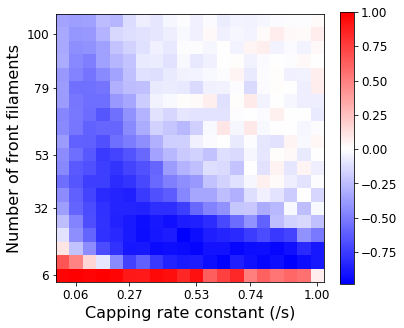

In [144]:
fig1_hand, axes1_hand = subplots()
fig1_hand.set_figheight(5)
im_hand = axes1_hand.imshow(flip(order_parameter_mat, 0).mean(axis=-1), cmap=get_cmap('bwr'))
axes1_hand.set_xlabel('Capping rate constant (/s)', fontsize=16)
ticks_row = linspace(1, num_intervals - 1, 5, dtype=int)
x_label_row = []
y_label_row = []
for i in ticks_row:
    x_label_row.append('{:.2f}'.format(capping_rate_const_row[i]))
    y_label_row.append('{:n}'.format(num_front_filaments_row[-i]))
axes1_hand.set_xticks(ticks_row)
axes1_hand.set_xticklabels(x_label_row, fontsize=12)
axes1_hand.set_yticks(ticks_row)
axes1_hand.set_yticklabels(y_label_row, fontsize=12)
axes1_hand.set_ylabel('Number of front filaments', fontsize=16)
bar_hand = fig1_hand.colorbar(im_hand)
bar_hand.ax.tick_params(labelsize=12)
fig1_hand.savefig('front-filament-vs-capping-phase-diagram.eps')

In [143]:
dump_session('apr-30-session.db')